### Prepare

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
from keras.models import Model,Sequential
from keras.layers import Input, Reshape, Dot, Embedding, Flatten
from keras.layers import Concatenate, Dense, Dropout, Embedding
from keras.layers import Add, Activation, Lambda
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
# from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PKL-JTK-Eben/FIX REC/movie.csv')

In [ ]:
user_enc = LabelEncoder()
data['user'] = user_enc.fit_transform(data['userId'].values)
n_users = data['user'].nunique()
item_enc = LabelEncoder()
data['movie'] = item_enc.fit_transform(data['movieId'].values)
n_movies = data['movie'].nunique()

In [ ]:
data['rating'] = data['rating'].values.astype(np.float32)
min_rating = min(data['rating'])
max_rating = max(data['rating'])

In [ ]:
X = data[['user', 'movie']].values
y = data['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
n_factors = 200
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
num_users = len(data.userId.unique())
num_movies = len(data.movieId.unique())

In [ ]:
EMBEDDING_SIZE = 100

### ModelV1

In [ ]:
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)

    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)

    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
model = RecommenderV1(n_users, n_movies, n_factors)
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_50 (Embedding)       (None, 1, 200)       134200      ['input_35[0][0]']               
                                                                                                  
 embedding_51 (Embedding)       (None, 1, 200)       357200      ['input_36[0][0]']               
                                                                                           

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
#                     verbose=1, validation_data=(X_test_array, y_test))

### ModelV2

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


### ModelV3

In [ ]:

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors

    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)

    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
model = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_52 (Embedding)       (None, 1, 200)       134200      ['input_37[0][0]']               
                                                                                                  
 embedding_54 (Embedding)       (None, 1, 200)       357200      ['input_38[0][0]']               
                                                                                           

In [ ]:
# history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
#                     verbose=1, validation_data=(X_test_array, y_test))

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


### ModelV4

In [ ]:

def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)

    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)

    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)

    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_56 (Embedding)       (None, 1, 200)       134200      ['input_39[0][0]']               
                                                                                                  
 embedding_57 (Embedding)       (None, 1, 200)       357200      ['input_40[0][0]']               
                                                                                           

In [ ]:
# history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
#                     verbose=1, validation_data=(X_test_array, y_test))

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


### ModelV5

In [ ]:

def RecommenderNet2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors)(user)
    u = Flatten()(u)
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors)(movie)
    m = Flatten()(m)

    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)

    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Dropout(0.5)(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)



    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
model = RecommenderNet2(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_42 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_58 (Embedding)       (None, 1, 200)       134200      ['input_41[0][0]']               
                                                                                                  
 embedding_59 (Embedding)       (None, 1, 200)       357200      ['input_42[0][0]']               
                                                                                           

In [ ]:
# history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
#                     verbose=1, validation_data=(X_test_array, y_test))

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


### ModelV6

In [ ]:

def RecommenderNet3(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors)(user)

    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors)(movie)

    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)

    x = Dense(10, activation='relu')(x)
    x = Activation('sigmoid')(x)
    x = Dropout(0.5)(x)

    x = Dense(1, activation='relu')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    x = Flatten()(x)

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
model = RecommenderNet3(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 200)       134200      ['input_5[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 200)       357200      ['input_6[0][0]']                
                                                                                            

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
444/444 [==============================] - 3s 5ms/step - loss: 1.5254 - val_loss: 0.9108
Epoch 2/20
444/444 [==============================] - 2s 5ms/step - loss: 1.0816 - val_loss: 0.8748
Epoch 3/20
444/444 [==============================] - 2s 4ms/step - loss: 0.9858 - val_loss: 0.8929
Epoch 4/20
444/444 [==============================] - 2s 4ms/step - loss: 0.9667 - val_loss: 0.8925
Epoch 5/20
444/444 [==============================] - 2s 4ms/step - loss: 0.9546 - val_loss: 0.8875
Epoch 6/20
444/444 [==============================] - 2s 4ms/step - loss: 0.9507 - val_loss: 0.8866
Epoch 7/20
444/444 [==============================] - 2s 4ms/step - loss: 0.9472 - val_loss: 0.8867
Epoch 8/20
444/444 [==============================] - 2s 5ms/step - loss: 0.9394 - val_loss: 0.8815
Epoch 9/20
444/444 [==============================] - 2s 5ms/step - loss: 0.9360 - val_loss: 0.8803
Epoch 10/20
444/444 [==============================] - 2s 4ms/step - loss: 0.9311 - val_loss: 0.8794

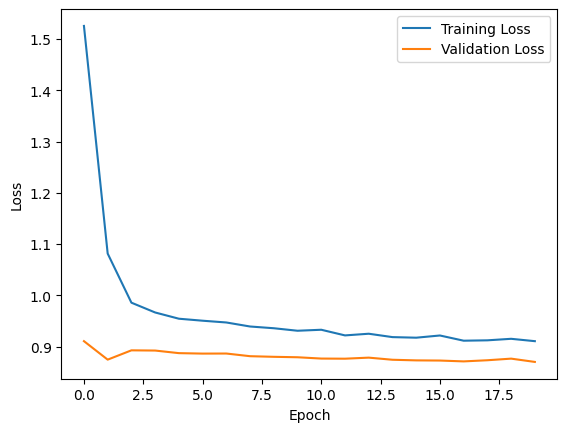

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


### ModelV7

In [ ]:

def RecommenderNet4(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors)(user)

    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors)(movie)

    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)

    x = Dense(10, activation='relu')(x)
    x = Activation('sigmoid')(x)
    x = Dropout(0.5)(x)

    x = LSTM(100)(x)

    x = Dense(1, activation='relu')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    x = Flatten()(x)

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
# model = RecommenderNet4(n_users, n_movies, n_factors, min_rating, max_rating)
# model.summary()

In [ ]:
# history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
#                     verbose=1, validation_data=(X_test_array, y_test))

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


### ModelV8

In [ ]:
train, test = train_test_split(data, test_size=0.2)
n_users = len(data.userId.unique())
n_movies = len(data.movieId.unique())

In [ ]:
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))
user_embedding = Embedding(n_users, 200)(user_input)
movie_embedding = Embedding(n_movies, 200)(movie_input)

user_flatten = Flatten()(user_embedding)
movie_flatten = Flatten()(movie_embedding)

dot = Dot(axes=1)([user_flatten, movie_flatten])
dense_layer = Dense(128, activation='relu')(dot)

model = Model([user_input, movie_input], dense_layer)

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
#                     verbose=1, validation_data=(X_test_array, y_test))

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
data.head()

,Unnamed: 0,genres,movieId,original_title,tagline,userId,rating,cast,keywords,user,movie
0,0,"['Action', 'Crime', 'Drama', 'Thriller']",949,Heat,A Los Angeles Crime Saga,23,3.5,"['Al Pacino', 'Robert De Niro', 'Val Kilmer', ...","['robbery', 'detective', 'bank', 'obsession', ...",22,483
1,1,"['Action', 'Crime', 'Drama', 'Thriller']",949,Heat,A Los Angeles Crime Saga,102,4.0,"['Al Pacino', 'Robert De Niro', 'Val Kilmer', ...","['robbery', 'detective', 'bank', 'obsession', ...",101,483
2,2,"['Action', 'Crime', 'Drama', 'Thriller']",949,Heat,A Los Angeles Crime Saga,232,2.0,"['Al Pacino', 'Robert De Niro', 'Val Kilmer', ...","['robbery', 'detective', 'bank', 'obsession', ...",231,483
3,3,"['Action', 'Crime', 'Drama', 'Thriller']",949,Heat,A Los Angeles Crime Saga,242,5.0,"['Al Pacino', 'Robert De Niro', 'Val Kilmer', ...","['robbery', 'detective', 'bank', 'obsession', ...",241,483
4,4,"['Action', 'Crime', 'Drama', 'Thriller']",949,Heat,A Los Angeles Crime Saga,263,3.0,"['Al Pacino', 'Robert De Niro', 'Val Kilmer', ...","['robbery', 'detective', 'bank', 'obsession', ...",262,483


In [ ]:
from keras.layers import Dot, multiply, concatenate

### ModelV9

In [ ]:
users = data.userId.unique()
movies = data.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}


data['userId'] = data['userId'].apply(lambda x: userid2idx[x])
data['movieId'] = data['movieId'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(data)) < 0.8
train = data[split]
valid = data[~split]
print(train.shape , valid.shape)



n_latent_factors=50
n_movies=len(data['movieId'].unique())
n_users=len(data['userId'].unique())


user_input=Input(shape=(1,),name='user_input',dtype='int64')
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec=Flatten(name='FlattenUsers')(user_embedding)
user_vec=Dropout(0.40)(user_vec)

(25179, 11) (6373, 11)


In [ ]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)
movie_vec=Dropout(0.40)(movie_vec)


sim=Dot(axes=1)([user_vec,movie_vec])

In [ ]:

from keras.layers import Input, Embedding, Flatten, Dot, Dense,LSTM, BatchNormalization
from keras.models import Model

nn_inp=Dense(128,activation='relu')(sim)
nn_inp=Dropout(0.4)(nn_inp)
nn_inp=BatchNormalization()(nn_inp)

nn_inp=Dense(128,activation='relu')(nn_inp)
nn_inp=Dropout(0.4)(nn_inp)
nn_inp=BatchNormalization()(nn_inp)

nn_inp=Dense(1,activation='relu')(nn_inp)
nn_model =Model([user_input, movie_input],nn_inp)
nn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 50)        33550       ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 50)        89300       ['movie_input[0][0]']            
                                                                                              

In [ ]:

nn_model.compile('adam', 'mean_squared_error')

In [ ]:

batch_size = 64
epochs = 100

History = nn_model.fit([train.userId,train.movieId],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.userId,valid.movieId],valid.rating),
                              verbose = 1)

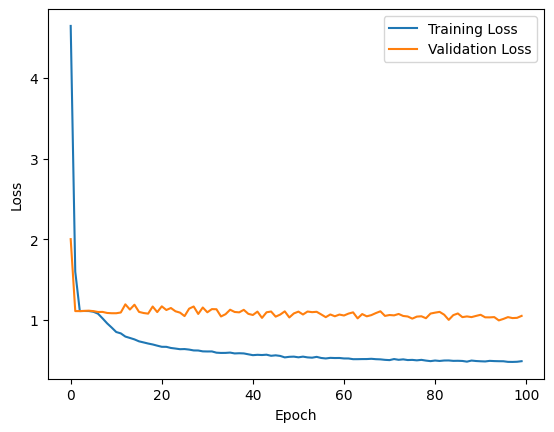

In [ ]:
import matplotlib.pyplot as plt
plt.plot(History.history['loss'], label='Training Loss')
plt.plot(History.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# movie_data = np.array(list(set(data.movieId)))
# movie_data[:5]
# user = np.array([14 for i in range(len(movie_data))])
# user[:5]
# predictions = model.predict([user, movie_data])
# predictions = np.array([a[0] for a in predictions])
# recommended_movie_ids = (-predictions).argsort()[:5]
# print(recommended_movie_ids)
# print(predictions[recommended_movie_ids])

### ModelV10

In [ ]:
print(num_users, num_movies)

671 1786


In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
print("Train size:", train_df.shape)    # 80.00%
print("Test size:", test_df.shape)      # 20.00%

X_train = train_df[['userId', 'movieId']].values
y_train = train_df['rating'].values
X_test = test_df[['userId', 'movieId']].values
y_test = test_df['rating'].values

X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

Train size: (25241, 11)
Test size: (6311, 11)


In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Embedding
from keras.regularizers import l2
from keras.activations import sigmoid

# number of latent factors in the embedding space
num_factors = 50

user = Input(shape=(1,), name='user-input')
u = Embedding(num_users,
              num_factors,
              embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-6),
              name='user-embedding')(user)
u = Reshape((num_factors,), name='user-flatten')(u)

movie = Input(shape=(1,), name='movie-input')
m = Embedding(num_movies,
              num_factors,
              embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-6),
              name='movie-embedding')(movie)
m = Reshape((num_factors,), name='movie-flatten')(m)

rating = Dot(axes=1, name='dot-product')([u, m])
# Convert to rating scale.
converted_rating = sigmoid(rating) * 5
model = Model(inputs=[user, movie], outputs=converted_rating)
model.compile(loss='mean_squared_error',
              optimizer='adam')

In [ ]:
# history = model.fit(X_train_array, y_train, validation_split = 0.2, epochs=30)

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

### ModelV11

In [ ]:
from keras.layers import Embedding, Flatten, Input, concatenate, Dropout, Dense
from keras.activations import sigmoid

num_factors = 50
movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies,
                            num_factors,
                            name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users,
                           num_factors,
                           name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

concat = concatenate([movie_vec, user_vec], name='movie-user-concat')

concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
rating = Dense(1, name='rating')(fc_2_dropout)
# Convert to rating scale.
converted_rating = sigmoid(rating) * 5
model = Model([user_input, movie_input], converted_rating)
model.compile(loss = 'mean_squared_error', optimizer='adam')

model.summary()



Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding (Embedding)    (None, 1, 50)        89300       ['movie-input[0][0]']            
                                                                                                  
 user-embedding (Embedding)     (None, 1, 50)        33550       ['user-input[0][0]']             
                                                                                           

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

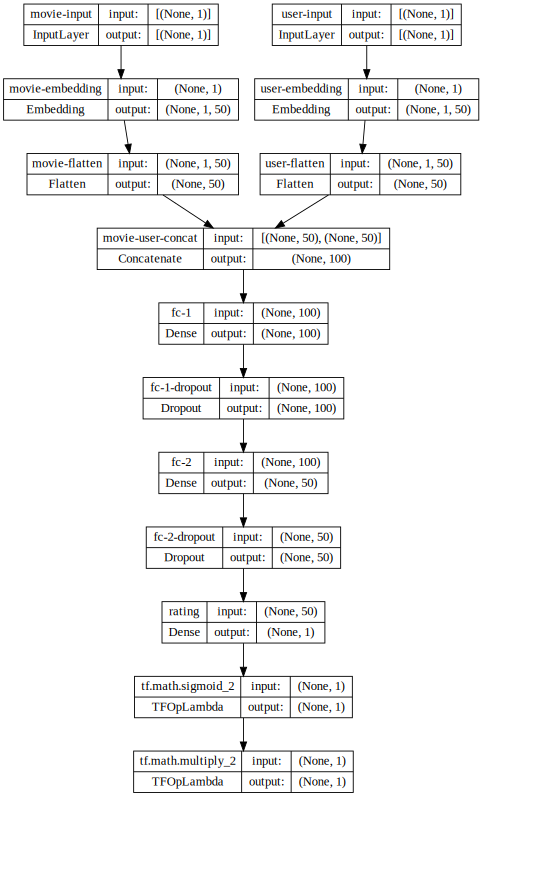

In [ ]:
SVG(model_to_dot(model, show_shapes=True, dpi=80).create(prog='dot', format='svg'))

In [ ]:

# history = model.fit(X_train_array, y_train, validation_split = 0.2, epochs=30)

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

### ModelV12

In [ ]:
df = data.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],)

In [ ]:



class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

lr = ReduceLROnPlateau(patience=4, verbose=1, min_lr=0.000001)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=25,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks = [lr])

Epoch 1/25
444/444 [==============================] - 3s 5ms/step - loss: 0.6510 - val_loss: 0.6236 - lr: 0.0010
Epoch 2/25
444/444 [==============================] - 2s 5ms/step - loss: 0.6260 - val_loss: 0.6776 - lr: 0.0010
Epoch 3/25
444/444 [==============================] - 2s 5ms/step - loss: 0.6246 - val_loss: 0.6135 - lr: 0.0010
Epoch 4/25
444/444 [==============================] - 3s 7ms/step - loss: 0.6162 - val_loss: 0.6647 - lr: 0.0010
Epoch 5/25
444/444 [==============================] - 3s 6ms/step - loss: 0.6145 - val_loss: 0.6117 - lr: 0.0010
Epoch 6/25
444/444 [==============================] - 2s 5ms/step - loss: 0.6111 - val_loss: 0.6637 - lr: 0.0010
Epoch 7/25
444/444 [==============================] - 2s 4ms/step - loss: 0.6148 - val_loss: 0.6075 - lr: 0.0010
Epoch 8/25
444/444 [==============================] - 2s 4ms/step - loss: 0.6120 - val_loss: 0.6624 - lr: 0.0010
Epoch 9/25
444/444 [==============================] - 2s 5ms/step - loss: 0.6146 - val_loss: 0.6

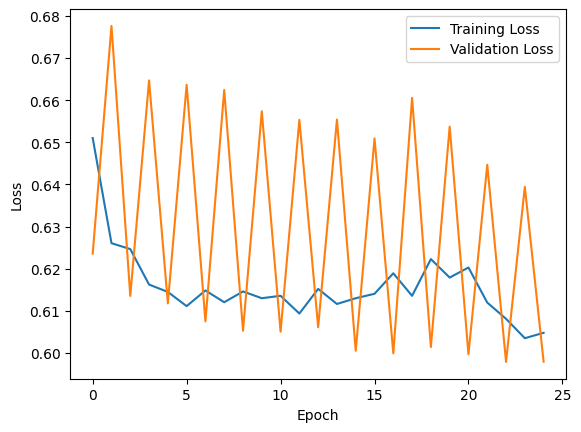

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

###ModelV14

In [ ]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1, activation="relu")

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias
        x = self.flatten(x)
        x = self.dense(x)
        return x


In [ ]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(),
)

In [ ]:
history = model.fit(x=x_train, y=y_train, epochs=25, batch_size=64,  validation_data=(x_val, y_val))

Epoch 1/25
444/444 [==============================] - 2s 3ms/step - loss: 0.1948 - val_loss: 0.0967
Epoch 2/25
444/444 [==============================] - 1s 3ms/step - loss: 0.1905 - val_loss: 0.4195
Epoch 3/25
444/444 [==============================] - 2s 4ms/step - loss: 0.2656 - val_loss: 0.0888
Epoch 4/25
444/444 [==============================] - 2s 4ms/step - loss: 0.2103 - val_loss: 0.3939
Epoch 5/25
444/444 [==============================] - 1s 3ms/step - loss: 0.1896 - val_loss: 0.0856
Epoch 6/25
444/444 [==============================] - 1s 3ms/step - loss: 0.1263 - val_loss: 0.3050
Epoch 7/25
444/444 [==============================] - 1s 3ms/step - loss: 0.0942 - val_loss: 0.1164
Epoch 8/25
444/444 [==============================] - 1s 3ms/step - loss: 0.0737 - val_loss: 0.1658
Epoch 9/25
444/444 [==============================] - 1s 3ms/step - loss: 0.0617 - val_loss: 0.1305
Epoch 10/25
444/444 [==============================] - 1s 3ms/step - loss: 0.0548 - val_loss: 0.1202

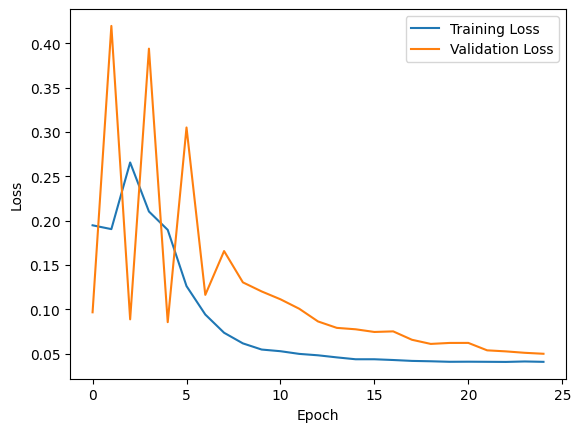

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_val, y_val_pred))

99/99 [==============================] - 0s 896us/step


In [ ]:
print(f"RMSE for Training Data: {rmse_train:.4f}")
print(f"RMSE for Test Data: {rmse_test:.4f}")

RMSE for Training Data: 0.2079
RMSE for Test Data: 0.2365


### ModelV13

In [ ]:
print(num_users, num_movies)

671 1786


In [ ]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1, activation="sigmoid")

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias
        x = self.flatten(x)
        x = self.dense(x)
        return x
    def build(self, input_shape):
        super().build(input_shape)


In [ ]:
# model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

# lr = ReduceLROnPlateau(patience=4, verbose=1, min_lr=0.000001)

# model.compile(
#     loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
# )

In [ ]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(),
)

In [ ]:
# model.summary()

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=25,
    verbose=1,
    validation_data=(x_val, y_val))

Epoch 1/25
444/444 [==============================] - 3s 5ms/step - loss: 0.0647 - val_loss: 0.0806
Epoch 2/25
444/444 [==============================] - 2s 5ms/step - loss: 0.0586 - val_loss: 0.0645
Epoch 3/25
444/444 [==============================] - 3s 6ms/step - loss: 0.0565 - val_loss: 0.0606
Epoch 4/25
444/444 [==============================] - 3s 7ms/step - loss: 0.0557 - val_loss: 0.0586
Epoch 5/25
444/444 [==============================] - 2s 5ms/step - loss: 0.0557 - val_loss: 0.0587
Epoch 6/25
444/444 [==============================] - 2s 5ms/step - loss: 0.0552 - val_loss: 0.0578
Epoch 7/25
444/444 [==============================] - 2s 4ms/step - loss: 0.0551 - val_loss: 0.0577
Epoch 8/25
444/444 [==============================] - 2s 4ms/step - loss: 0.0548 - val_loss: 0.0576
Epoch 9/25
444/444 [==============================] - 2s 5ms/step - loss: 0.0546 - val_loss: 0.0574
Epoch 10/25
444/444 [==============================] - 4s 8ms/step - loss: 0.0544 - val_loss: 0.0572

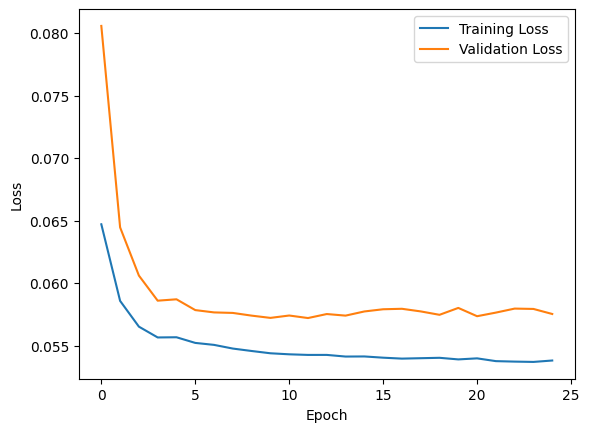

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_val, y_val_pred))

99/99 [==============================] - 0s 1ms/step


In [ ]:
print(f"RMSE for Training Data: {rmse_train:.4f}")
print(f"RMSE for Test Data: {rmse_test:.4f}")

RMSE for Training Data: 0.2377
RMSE for Test Data: 0.2383


### Recommender

In [ ]:
df = data
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
min_rating = min(df["rating"])
max_rating = max(df["rating"])


In [ ]:
user_id = 670

movie_df = pd.read_csv('/content/drive/MyDrive/PKL-JTK-Eben/FIX REC/movie.csv')
movie_df.drop_duplicates(subset='movieId', keep='first', inplace=True)
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]

for row in recommended_movies.itertuples():
    print(row.original_title)



56/56 [==============================] - 0s 853us/step
Top 10 movie recommendations
--------------------------------
Mr. Jones
Snow White and the Seven Dwarfs
La double vie de Véronique
Fried Green Tomatoes
Ghost Dog: The Way of the Samurai
Mr. Destiny
Code 46
The Times of Harvey Milk
1942: A Love Story
The Liquidator


In [ ]:
def generate_movie_recommendations(user_id, model, movie_df, user2user_encoded, movie2movie_encoded, movie_encoded2movie):
    movies_watched_by_user = movie_df[movie_df.userId == user_id]
    movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
    movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))
    ratings = model.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-10:][::-1]

    recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]
    recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]

    return recommended_movies

In [ ]:
user_id = 500
recommended_movies = generate_movie_recommendations(user_id, model, movie_df,
                                                    user2user_encoded,
                                                    movie2movie_encoded,
                                                    movie_encoded2movie)

print("Top 10 movie recommendations for User", user_id)
print("----" * 8)
for row in recommended_movies.itertuples():
    print(row.original_title)


56/56 [==============================] - 0s 808us/step
Top 10 movie recommendations for User 500
--------------------------------
Apollo 13
Snow White and the Seven Dwarfs
Ghost Dog: The Way of the Samurai
Moonraker
About Schmidt
장화, 홍련
The Times of Harvey Milk
The Lake House
1942: A Love Story
Ginger


In [ ]:
user_id = 100
recommended_movies = generate_movie_recommendations(user_id, model, movie_df, user2user_encoded, movie2movie_encoded, movie_encoded2movie)

print("Top 10 movie recommendations for User", user_id)
print("----" * 8)
for row in recommended_movies.itertuples():
    print(row.original_title)

56/56 [==============================] - 0s 1ms/step
Top 10 movie recommendations for User 100
--------------------------------
Nell
Mr. Jones
Ghost Dog: The Way of the Samurai
Mr. Destiny
Code 46
Ascenseur pour l'échafaud
Lady in the Lake
Bloodbath at the House of Death
Ginger
Long Pigs


In [ ]:
user_id = 1
recommended_movies = generate_movie_recommendations(user_id, model, movie_df, user2user_encoded, movie2movie_encoded, movie_encoded2movie)

print("Top 10 movie recommendations for User", user_id)
print("----" * 8)
for row in recommended_movies.itertuples():
    print(row.original_title)

56/56 [==============================] - 0s 977us/step
Top 10 movie recommendations for User 1
--------------------------------
Apollo 13
Around the World in Eighty Days
La double vie de Véronique
Le Grand Bleu
Moonraker
Very Annie Mary
Bloodbath at the House of Death
Mirror Mirror
Ginger
The Liquidator


In [ ]:
user_id = 2
recommended_movies = generate_movie_recommendations(user_id, model, movie_df, user2user_encoded, movie2movie_encoded, movie_encoded2movie)

print("Top 10 movie recommendations for User", user_id)
print("----" * 8)
for row in recommended_movies.itertuples():
    print(row.original_title)

55/55 [==============================] - 0s 878us/step
Top 10 movie recommendations for User 2
--------------------------------
Apollo 13
Around the World in Eighty Days
Dial M for Murder
Ghost Dog: The Way of the Samurai
Per qualche dollaro in più
Shaft
M*A*S*H
The Sum of All Fears
장화, 홍련
Ginger


In [ ]:
user_id = 3
recommended_movies = generate_movie_recommendations(user_id, model, movie_df, user2user_encoded, movie2movie_encoded, movie_encoded2movie)

print("Top 10 movie recommendations for User", user_id)
print("----" * 8)
for row in recommended_movies.itertuples():
    print(row.original_title)

56/56 [==============================] - 0s 820us/step
Top 10 movie recommendations for User 3
--------------------------------
Around the World in Eighty Days
Ghost Dog: The Way of the Samurai
Moonraker
Out of Rosenheim
The Sum of All Fears
About Schmidt
Pillow Talk
장화, 홍련
The Prime of Miss Jean Brodie
Blondie Goes Latin
